# Movie Recommendation System Using Collaborative Filtering and Machine Learning

**Course:** CSCI 6970 – Machine Learning  
**Project:** Final Course Project – MS in Computer Science  
**Author:** Nakul Magotra  

This notebook implements an end-to-end movie recommendation system using:

1. **Collaborative Filtering**  
   - Item-based k-Nearest Neighbors (Item-kNN)  
   - User-based k-Nearest Neighbors (User-kNN)

2. **Matrix Factorization**  
   - Truncated SVD on the user–item rating matrix

3. **Feature-based Machine Learning Model**  
   - Gradient-boosted trees (XGBoost if available, otherwise GradientBoostingRegressor)

We use the **MovieLens 20M** dataset and follow a **leave-one-out time-based split per user** for evaluation.  
The notebook is structured to support both **quantitative evaluation** and **qualitative analysis** (top-N recommendations, error diagnostics, and visualizations) for the final project report.


In [1]:
# 1. Environment Setup & Imports

import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, List
from tqdm.auto import tqdm


import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
)
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
import seaborn as sns

# Try to import XGBoost; fall back to GradientBoostingRegressor if unavailable
try:
    from xgboost import XGBRegressor  # type: ignore
    HAS_XGBOOST = True
except Exception:
    from sklearn.ensemble import GradientBoostingRegressor
    HAS_XGBOOST = False

sns.set(style="whitegrid")


In [2]:
# 2. Configuration & Reproducibility

@dataclass
class Config:
    # TODO: update this path to where your MovieLens 20M data lives
    data_dir: Path = Path("/content")
    ratings_file: str = "ratings.csv"
    movies_file: str = "movies.csv"

    # Filtering thresholds
    min_user_ratings: int = 20
    min_movie_ratings: int = 50

    # Global random split for ML model
    test_size: float = 0.2

    # Model hyperparameters
    knn_k: int = 50
    svd_components: int = 50

    # Subsample fraction for the ML model (to keep training feasible)
    ml_subsample_fraction: float = 0.1  # set 1.0 to use all filtered ratings

    random_seed: int = 42


CFG = Config()


def set_seed(seed: int = 42) -> None:
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)


set_seed(CFG.random_seed)


## 1. Data Loading and Preprocessing

In this section we:

1. Load **MovieLens 20M** ratings and movie metadata.
2. Filter:
   - Users with fewer than `min_user_ratings` interactions.
   - Movies with fewer than `min_movie_ratings` ratings.
3. Create a **time-based leave-one-out split** per user:
   - Last interaction → test set.
   - Remaining interactions → train set.


In [3]:
# 3. Data Loading & Filtering


def load_movielens_20m(cfg: Config) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load MovieLens 20M ratings and movies metadata.

    Returns
    -------
    ratings : DataFrame [userId, movieId, rating, timestamp]
    movies  : DataFrame [movieId, title, genres]
    """
    ratings_path = cfg.data_dir / cfg.ratings_file
    movies_path = cfg.data_dir / cfg.movies_file

    if not ratings_path.exists():
        raise FileNotFoundError(f"Ratings file not found at: {ratings_path}")
    if not movies_path.exists():
        raise FileNotFoundError(f"Movies file not found at: {movies_path}")

    ratings = pd.read_csv(ratings_path)
    movies = pd.read_csv(movies_path)
    return ratings, movies


def filter_ratings(
    ratings: pd.DataFrame,
    min_user_ratings: int,
    min_movie_ratings: int,
) -> pd.DataFrame:
    """
    Filter out very inactive users and very unpopular movies
    to keep the matrix denser and more tractable.
    """
    # Filter by user activity
    user_counts = ratings["userId"].value_counts()
    active_users = user_counts[user_counts >= min_user_ratings].index
    ratings = ratings[ratings["userId"].isin(active_users)]

    # Filter by movie popularity
    movie_counts = ratings["movieId"].value_counts()
    popular_movies = movie_counts[movie_counts >= min_movie_ratings].index
    ratings = ratings[ratings["movieId"].isin(popular_movies)]

    ratings = ratings.reset_index(drop=True)
    return ratings


def train_test_split_leave_one_out(
    ratings: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Leave-one-out split per user based on timestamp:
    For each user, the most recent rating goes to the test set,
    the rest remain in the training set.
    """
    ratings_sorted = ratings.sort_values(["userId", "timestamp"])
    last_idx = ratings_sorted.groupby("userId")["timestamp"].idxmax()

    test_mask = ratings_sorted.index.isin(last_idx)
    test_df = ratings_sorted.loc[test_mask].copy()
    train_df = ratings_sorted.loc[~test_mask].copy()

    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


print("=== Loading MovieLens 20M data ===")
ratings_raw, movies = load_movielens_20m(CFG)
print(f"Raw ratings: {len(ratings_raw):,}")
print(f"Raw movies : {len(movies):,}")

print("\n=== Filtering sparse users and movies ===")
ratings_filtered = filter_ratings(
    ratings_raw,
    min_user_ratings=CFG.min_user_ratings,
    min_movie_ratings=CFG.min_movie_ratings,
)
print(f"Filtered ratings: {len(ratings_filtered):,}")
print(f"Unique users   : {ratings_filtered['userId'].nunique():,}")
print(f"Unique movies  : {ratings_filtered['movieId'].nunique():,}")

print("\n=== Time-based leave-one-out train/test split per user ===")
train_df, test_df = train_test_split_leave_one_out(ratings_filtered)
print(f"Train size: {len(train_df):,}")
print(f"Test size : {len(test_df):,}")


=== Loading MovieLens 20M data ===
Raw ratings: 1,077,104
Raw movies : 27,278

=== Filtering sparse users and movies ===
Filtered ratings: 970,723
Unique users   : 7,328
Unique movies  : 3,328

=== Time-based leave-one-out train/test split per user ===
Train size: 963,395
Test size : 7,328


In [17]:
print("Movies DataFrame Head:")
display(movies.head(5))

Movies DataFrame Head:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
print("Ratings Filtered DataFrame Head:")
display(ratings_filtered.head(5))

Ratings Filtered DataFrame Head:


,userId,movieId,rating,timestamp
0,1,2,3.5,1.112486e+09
1,1,29,3.5,1.112485e+09
2,1,32,3.5,1.112485e+09
3,1,47,3.5,1.112485e+09
4,1,50,3.5,1.112485e+09


## 2. Exploratory Data Analysis (EDA)

We briefly explore:

- Rating distribution.
- Number of ratings per user.
- Number of ratings per movie.

These plots help justify the filtering thresholds and highlight the long-tail nature
of user and item activity.


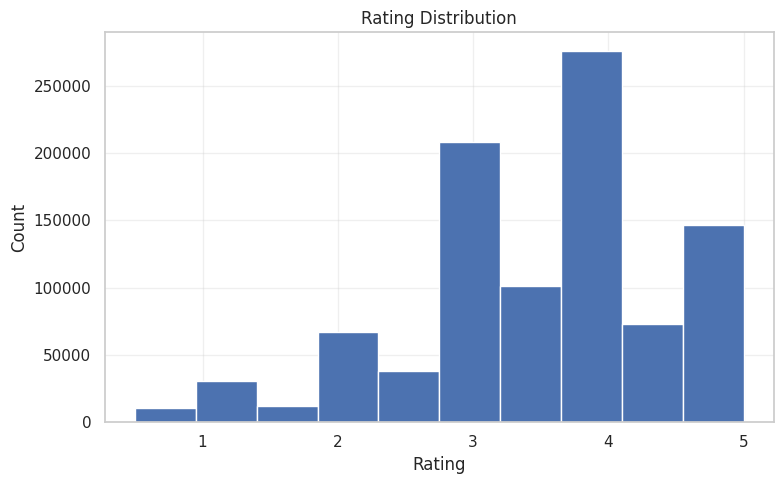

user_counts describe:
 count    7328.000000
mean      131.467658
std       179.494734
min         5.000000
25%        32.000000
50%        65.000000
75%       150.000000
max      1883.000000
Name: count, dtype: float64


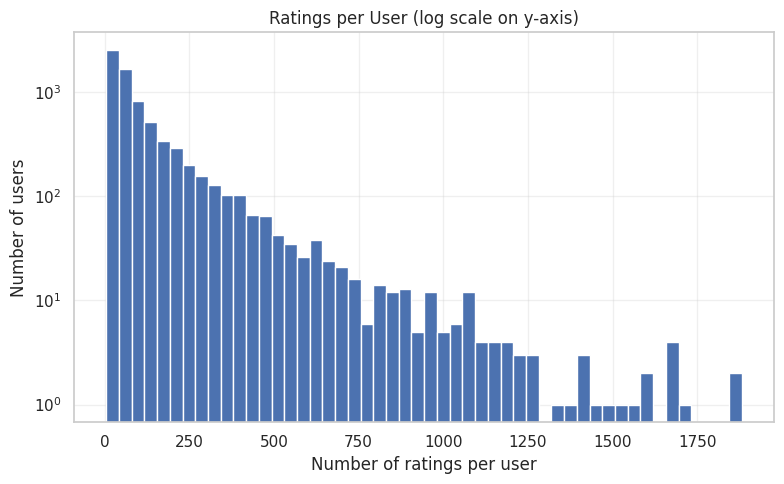

movie_counts describe:
 count    3328.000000
mean      289.481671
std       385.347186
min        47.000000
25%        79.000000
50%       146.000000
75%       323.000000
max      3579.000000
Name: count, dtype: float64


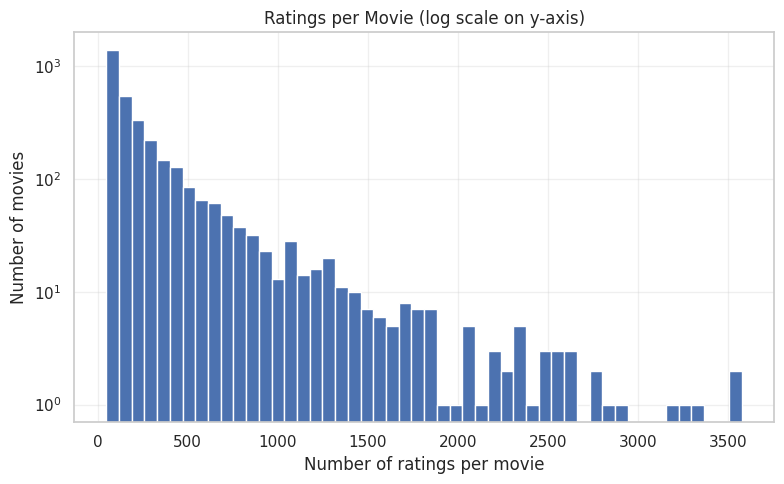

In [6]:
# 4. Exploratory Data Analysis (EDA)

def plot_basic_statistics(ratings_df, output_dir="figures"):
    """
    Plot rating distribution, ratings per user, and ratings per movie
    using the MovieLens-style schema:
    columns = ['userId', 'movieId', 'rating', 'timestamp'].
    """
    os.makedirs(output_dir, exist_ok=True)

    # 1) Rating distribution
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(ratings_df["rating"], bins=10)
    ax.set_title("Rating Distribution")
    ax.set_xlabel("Rating")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)

    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "figure_01.png"), dpi=300)
    plt.show()

    # 2) Ratings per user
    user_counts = ratings_df["userId"].value_counts()
    print("user_counts describe:\n", user_counts.describe())

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(user_counts, bins=50)
    ax.set_yscale("log")
    ax.set_title("Ratings per User (log scale on y-axis)")
    ax.set_xlabel("Number of ratings per user")
    ax.set_ylabel("Number of users")
    ax.grid(True, alpha=0.3)

    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "figure_02.png"), dpi=300)
    plt.show()

    # 3) Ratings per movie
    movie_counts = ratings_df["movieId"].value_counts()
    print("movie_counts describe:\n", movie_counts.describe())

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(movie_counts, bins=50)
    ax.set_yscale("log")
    ax.set_title("Ratings per Movie (log scale on y-axis)")
    ax.set_xlabel("Number of ratings per movie")
    ax.set_ylabel("Number of movies")
    ax.grid(True, alpha=0.3)

    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "figure_03.png"), dpi=300)
    plt.show()


plot_basic_statistics(train_df)


## 3. Building User–Item Matrix

Next, we:

1. Map raw `userId` and `movieId` to contiguous indices.
2. Construct a sparse **user–item rating matrix** in CSR format.

This matrix is the foundation for all collaborative filtering and matrix
factorization approaches.


In [7]:
# 5. ID Mappings & Sparse User–Item Matrix


def build_id_mappings(
    ratings: pd.DataFrame,
) -> Tuple[
    Dict[int, int],
    Dict[int, int],
    Dict[int, int],
    Dict[int, int],
]:
    """
    Map raw userId and movieId to contiguous indices.
    """
    unique_users = ratings["userId"].unique()
    unique_movies = ratings["movieId"].unique()

    user_id_to_index = {uid: idx for idx, uid in enumerate(unique_users)}
    index_to_user_id = {idx: uid for uid, idx in user_id_to_index.items()}

    movie_id_to_index = {mid: idx for idx, mid in enumerate(unique_movies)}
    index_to_movie_id = {idx: mid for mid, idx in movie_id_to_index.items()}

    return (
        user_id_to_index,
        index_to_user_id,
        movie_id_to_index,
        index_to_movie_id,
    )


def build_user_item_matrix(
    ratings: pd.DataFrame,
    user_id_to_index: Dict[int, int],
    movie_id_to_index: Dict[int, int],
) -> sparse.csr_matrix:
    """
    Build a sparse user–item rating matrix in CSR format (n_users x n_items).
    """
    row_indices = ratings["userId"].map(user_id_to_index)
    col_indices = ratings["movieId"].map(movie_id_to_index)
    values = ratings["rating"].astype(np.float32)

    n_users = len(user_id_to_index)
    n_items = len(movie_id_to_index)

    matrix = sparse.coo_matrix(
        (values, (row_indices, col_indices)),
        shape=(n_users, n_items),
        dtype=np.float32,
    )
    return matrix.tocsr()


(
    user_id_to_index,
    index_to_user_id,
    movie_id_to_index,
    index_to_movie_id,
) = build_id_mappings(train_df)

user_item_matrix = build_user_item_matrix(
    train_df, user_id_to_index, movie_id_to_index
)

print("User–Item matrix shape:", user_item_matrix.shape)
print("Non-zero entries       :", user_item_matrix.nnz)


User–Item matrix shape: (7328, 3328)
Non-zero entries       : 963395


## 4. Evaluation Metrics

We use two main metrics:

1. **RMSE (Root Mean Squared Error)** – standard rating prediction error metric.
2. **MAPE (Mean Absolute Percentage Error)** – interpretable as a percentage.

Both are computed on the held-out test set.


In [8]:
# 6. Evaluation Metrics


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    eps = 1e-8
    return float(
        mean_absolute_percentage_error(y_true + eps, y_pred + eps) * 100.0
    )


## 5. Collaborative Filtering & Matrix Factorization Models

We implement three core recommendation models:

1. **Item-based kNN Collaborative Filtering**  
   - Predicts ratings from similar items based on cosine similarity.

2. **User-based kNN Collaborative Filtering**  
   - Predicts ratings from similar users based on cosine similarity.

3. **Matrix Factorization via Truncated SVD**  
   - Learns low-dimensional user and item embeddings and reconstructs ratings as dot-products.


In [9]:
# 7. Collaborative Filtering & Matrix Factorization Models


class ItemKNNRecommender:
    """
    Item-based kNN recommender using cosine similarity.
    """

    def __init__(self, k: int = 50):
        self.k = k
        self.item_fitted = False

    def fit(self, user_item_matrix: sparse.csr_matrix) -> "ItemKNNRecommender":
        self.user_item_matrix = user_item_matrix

        knn = NearestNeighbors(
            n_neighbors=self.k + 1,  # include self, drop later
            metric="cosine",
            algorithm="brute",
            n_jobs=-1,
        )
        knn.fit(self.user_item_matrix.T)

        distances, indices = knn.kneighbors(self.user_item_matrix.T)
        similarities = 1.0 - distances

        self.item_neighbors = indices[:, 1:]        # drop self
        self.item_similarities = similarities[:, 1:]
        self.global_mean = self.user_item_matrix.data.mean()
        self.item_fitted = True
        return self

    def predict_single(self, user_index: int, item_index: int) -> float:
        if not self.item_fitted:
            raise RuntimeError("ItemKNN model is not fitted.")

        user_ratings = self.user_item_matrix[user_index, :]
        neighbors = self.item_neighbors[item_index]
        sims = self.item_similarities[item_index]

        neighbour_ratings = user_ratings[:, neighbors].toarray().flatten()
        mask = neighbour_ratings > 0

        if not np.any(mask):
            user_data = user_ratings.data
            if user_data.size > 0:
                return float(user_data.mean())
            return float(self.global_mean)

        sims = sims[mask]
        neighbour_ratings = neighbour_ratings[mask]

        if sims.sum() == 0:
            return float(neighbour_ratings.mean())

        pred = float(np.dot(sims, neighbour_ratings) / sims.sum())
        return pred

    def predict_batch(
        self,
        user_indices: np.ndarray,
        item_indices: np.ndarray,
    ) -> np.ndarray:
        preds = np.zeros(len(user_indices), dtype=np.float32)
        for idx, (u, i) in enumerate(zip(user_indices, item_indices)):
            preds[idx] = self.predict_single(int(u), int(i))
        return preds


class UserKNNRecommender:
    """
    User-based kNN recommender using cosine similarity.
    """

    def __init__(self, k: int = 50):
        self.k = k
        self.user_fitted = False

    def fit(self, user_item_matrix: sparse.csr_matrix) -> "UserKNNRecommender":
        self.user_item_matrix = user_item_matrix

        knn = NearestNeighbors(
            n_neighbors=self.k + 1,
            metric="cosine",
            algorithm="brute",
            n_jobs=-1,
        )
        knn.fit(self.user_item_matrix)

        distances, indices = knn.kneighbors(self.user_item_matrix)
        similarities = 1.0 - distances

        self.user_neighbors = indices[:, 1:]
        self.user_similarities = similarities[:, 1:]
        self.global_mean = self.user_item_matrix.data.mean()
        self.user_fitted = True
        return self

    def predict_single(self, user_index: int, item_index: int) -> float:
        if not self.user_fitted:
            raise RuntimeError("UserKNN model is not fitted.")

        item_column = self.user_item_matrix[:, item_index].toarray().flatten()

        if item_column.sum() == 0:
            user_data = self.user_item_matrix[user_index, :].data
            if user_data.size > 0:
                return float(user_data.mean())
            return float(self.global_mean)

        neighbours = self.user_neighbors[user_index]
        sims = self.user_similarities[user_index]

        neighbour_ratings = item_column[neighbours]
        mask = neighbour_ratings > 0

        if not np.any(mask):
            user_data = self.user_item_matrix[user_index, :].data
            if user_data.size > 0:
                return float(user_data.mean())
            return float(self.global_mean)

        sims = sims[mask]
        neighbour_ratings = neighbour_ratings[mask]

        if sims.sum() == 0:
            return float(neighbour_ratings.mean())

        pred = float(np.dot(sims, neighbour_ratings) / sims.sum())
        return pred

    def predict_batch(
        self,
        user_indices: np.ndarray,
        item_indices: np.ndarray,
    ) -> np.ndarray:
        preds = np.zeros(len(user_indices), dtype=np.float32)
        for idx, (u, i) in enumerate(zip(user_indices, item_indices)):
            preds[idx] = self.predict_single(int(u), int(i))
        return preds


class SVDBasedRecommender:
    """
    Matrix factorization using TruncatedSVD on the user–item matrix.
    """

    def __init__(self, n_components: int = 50, random_state: int = 42):
        self.n_components = n_components
        self.random_state = random_state
        self.fitted = False

    def fit(self, user_item_matrix: sparse.csr_matrix) -> "SVDBasedRecommender":
        self.user_item_matrix = user_item_matrix

        self.svd = TruncatedSVD(
            n_components=self.n_components,
            random_state=self.random_state,
        )
        user_latent = self.svd.fit_transform(self.user_item_matrix)
        item_latent = self.svd.components_.T

        self.user_factors = user_latent
        self.item_factors = item_latent
        self.global_mean = self.user_item_matrix.data.mean()
        self.fitted = True
        return self

    def predict_single(self, user_index: int, item_index: int) -> float:
        if not self.fitted:
            raise RuntimeError("SVD model is not fitted.")

        if user_index >= self.user_factors.shape[0]:
            return float(self.global_mean)
        if item_index >= self.item_factors.shape[0]:
            return float(self.global_mean)

        u_vec = self.user_factors[user_index, :]
        i_vec = self.item_factors[item_index, :]

        pred = float(np.dot(u_vec, i_vec))
        pred = float(np.clip(pred, 0.5, 5.0))
        return pred

    def predict_batch(
        self,
        user_indices: np.ndarray,
        item_indices: np.ndarray,
    ) -> np.ndarray:
        preds = np.zeros(len(user_indices), dtype=np.float32)
        for idx, (u, i) in enumerate(zip(user_indices, item_indices)):
            preds[idx] = self.predict_single(int(u), int(i))
        return preds


## 6. Feature-based Machine Learning Model

We also train a supervised learning model that uses:

- User-level statistics (mean rating, rating count, bias)
- Movie-level statistics (mean rating, rating count, bias)
- A simple normalized timestamp feature

as input to a tree-based regressor:

- **XGBoost** (if available) or
- **GradientBoostingRegressor** (fallback)

This model captures global patterns beyond pure similarity-based CF.


In [10]:
# 8. Feature-based ML Model & Feature Engineering


def build_aggregated_stats(
    ratings_train: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.DataFrame, float]:
    """
    Build per-user and per-movie aggregate statistics.
    """
    global_mean = ratings_train["rating"].mean()

    user_stats = ratings_train.groupby("userId")["rating"].agg(
        ["mean", "count"]
    ).rename(columns={"mean": "user_mean", "count": "user_count"})

    movie_stats = ratings_train.groupby("movieId")["rating"].agg(
        ["mean", "count"]
    ).rename(columns={"mean": "movie_mean", "count": "movie_count"})

    return user_stats, movie_stats, float(global_mean)


def add_features(
    ratings: pd.DataFrame,
    user_stats: pd.DataFrame,
    movie_stats: pd.DataFrame,
    global_mean: float,
) -> pd.DataFrame:
    """
    Join ratings with aggregated user/movie statistics
    and construct a feature matrix for supervised learning.
    """
    df = ratings.copy()
    df = df.join(user_stats, on="userId")
    df = df.join(movie_stats, on="movieId")

    df["user_mean"] = df["user_mean"].fillna(global_mean)
    df["movie_mean"] = df["movie_mean"].fillna(global_mean)
    df["user_count"] = df["user_count"].fillna(0)
    df["movie_count"] = df["movie_count"].fillna(0)

    df["user_bias"] = df["user_mean"] - global_mean
    df["movie_bias"] = df["movie_mean"] - global_mean

    if "timestamp" in df.columns:
        df["timestamp_norm"] = (
            df["timestamp"] - df["timestamp"].min()
        ) / (df["timestamp"].max() - df["timestamp"].min() + 1e-8)
    else:
        df["timestamp_norm"] = 0.0

    return df


class FeatureBasedRegressor:
    """
    Feature-based rating predictor using boosted trees.
    """

    def __init__(self, random_state: int = 42):
        self.random_state = random_state
        if HAS_XGBOOST:
            self.model = XGBRegressor(
                n_estimators=300,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                objective="reg:squarederror",
                random_state=self.random_state,
                tree_method="hist",
                n_jobs=-1,
            )
        else:
            self.model = GradientBoostingRegressor(
                n_estimators=300,
                max_depth=3,
                learning_rate=0.05,
                random_state=self.random_state,
            )

        self.feature_cols = [
            "user_mean",
            "movie_mean",
            "user_count",
            "movie_count",
            "user_bias",
            "movie_bias",
            "timestamp_norm",
        ]

    def fit(self, df_features: pd.DataFrame) -> "FeatureBasedRegressor":
        X = df_features[self.feature_cols].values
        y = df_features["rating"].values.astype(np.float32)
        self.model.fit(X, y)
        return self

    def predict(self, df_features: pd.DataFrame) -> np.ndarray:
        X = df_features[self.feature_cols].values
        preds = self.model.predict(X)
        preds = np.clip(preds, 0.5, 5.0)
        return preds.astype(np.float32)


## 7. Shared Evaluation Helper

We create a helper to generate a unified predictions DataFrame for CF/SVD models on the leave-one-out test set. This will be reused for:

- RMSE / MAPE computation
- residual analysis
- visualizations


In [11]:
# 9. Shared evaluation helper for CF/SVD models


def build_cf_predictions_df(
    model,
    test_df: pd.DataFrame,
    user_id_to_index: Dict[int, int],
    movie_id_to_index: Dict[int, int],
) -> pd.DataFrame:
    """
    Build a DataFrame with columns:
    [userId, movieId, rating, y_pred]
    for a given CF/SVD model on test_df.
    """
    mask = (
        test_df["userId"].isin(user_id_to_index.keys())
        & test_df["movieId"].isin(movie_id_to_index.keys())
    )
    df = test_df[mask].copy()

    user_indices = df["userId"].map(user_id_to_index).values
    item_indices = df["movieId"].map(movie_id_to_index).values

    if hasattr(model, "predict_batch"):
        preds = model.predict_batch(user_indices, item_indices)
    else:
        preds_list = []
        for u_idx, i_idx in zip(user_indices, item_indices):
            preds_list.append(model.predict_single(int(u_idx), int(i_idx)))
        preds = np.array(preds_list, dtype=np.float32)

    df["y_pred"] = preds.astype(np.float32)
    return df


## 8. Training and Evaluating All Models

We now:

1. Train:
   - Item-kNN
   - User-kNN
   - SVD-based MF
   - Feature-based ML model
2. Evaluate all of them using RMSE and MAPE.
3. Store predictions for later analysis and visualization.


In [12]:
# 10. Training & Evaluation

model_results = []
model_predictions = {}  # name -> DataFrame with (rating, y_pred)

print("Before cleanup, NaNs in .data:",
      np.isnan(user_item_matrix.data).any())

if sp.issparse(user_item_matrix):
    # Replace NaNs in the sparse data array with 0.0 (meaning: no rating)
    data = user_item_matrix.data
    nan_mask = np.isnan(data)
    data[nan_mask] = 0.0
    user_item_matrix.data = data.astype(np.float32, copy=False)

print("After cleanup, NaNs in .data:",
      np.isnan(user_item_matrix.data).any())

# ------------------------------------------------------------
# Run all models with a tqdm progress bar
# ------------------------------------------------------------
stages = ["Item-kNN", "User-kNN", "SVD", "Feature-ML"]

for stage in tqdm(stages, desc="Training & evaluation", leave=True):

    # --------------------------------------------------------
    # 8.1 Item-based kNN CF
    # --------------------------------------------------------
    if stage == "Item-kNN":
        print("\n=== Training Item-based kNN model ===")
        item_knn = ItemKNNRecommender(k=CFG.knn_k).fit(user_item_matrix)

        item_test_preds = build_cf_predictions_df(
            model=item_knn,
            test_df=test_df,
            user_id_to_index=user_id_to_index,
            movie_id_to_index=movie_id_to_index,
        )

        item_rmse = rmse(
            item_test_preds["rating"].values,
            item_test_preds["y_pred"].values,
        )
        item_mape = mape(
            item_test_preds["rating"].values,
            item_test_preds["y_pred"].values,
        )

        model_results.append(
            {"model": "Item-kNN", "rmse": item_rmse, "mape": item_mape}
        )
        model_predictions["Item-kNN"] = item_test_preds

        print(f"Item-kNN RMSE: {item_rmse:.4f}, MAPE: {item_mape:.2f}%")

    # --------------------------------------------------------
    # 8.2 User-based kNN CF
    # --------------------------------------------------------
    elif stage == "User-kNN":
        print("\n=== Training User-based kNN model ===")
        user_knn = UserKNNRecommender(k=CFG.knn_k).fit(user_item_matrix)

        user_test_preds = build_cf_predictions_df(
            model=user_knn,
            test_df=test_df,
            user_id_to_index=user_id_to_index,
            movie_id_to_index=movie_id_to_index,
        )

        user_rmse_val = rmse(
            user_test_preds["rating"].values,
            user_test_preds["y_pred"].values,
        )
        user_mape_val = mape(
            user_test_preds["rating"].values,
            user_test_preds["y_pred"].values,
        )

        model_results.append(
            {"model": "User-kNN", "rmse": user_rmse_val, "mape": user_mape_val}
        )
        model_predictions["User-kNN"] = user_test_preds

        print(f"User-kNN RMSE: {user_rmse_val:.4f}, MAPE: {user_mape_val:.2f}%")

    # --------------------------------------------------------
    # 8.3 SVD-based MF
    # --------------------------------------------------------
    elif stage == "SVD":
        print("\n=== Training SVD-based model ===")
        svd_model = SVDBasedRecommender(
            n_components=CFG.svd_components,
            random_state=CFG.random_seed,
        ).fit(user_item_matrix)

        svd_test_preds = build_cf_predictions_df(
            model=svd_model,
            test_df=test_df,
            user_id_to_index=user_id_to_index,
            movie_id_to_index=movie_id_to_index,
        )

        svd_rmse_val = rmse(
            svd_test_preds["rating"].values,
            svd_test_preds["y_pred"].values,
        )
        svd_mape_val = mape(
            svd_test_preds["rating"].values,
            svd_test_preds["y_pred"].values,
        )

        model_results.append(
            {"model": "SVD", "rmse": svd_rmse_val, "mape": svd_mape_val}
        )
        model_predictions["SVD"] = svd_test_preds

        print(f"SVD RMSE : {svd_rmse_val:.4f}, MAPE: {svd_mape_val:.2f}%")

    # --------------------------------------------------------
    # 8.4 Feature-based ML model
    # --------------------------------------------------------
    elif stage == "Feature-ML":
        print("\n=== Training feature-based ML model ===")

        ratings_ml = ratings_filtered.copy()
        if CFG.ml_subsample_fraction < 1.0:
            ratings_ml = ratings_ml.sample(
                frac=CFG.ml_subsample_fraction,
                random_state=CFG.random_seed,
            ).reset_index(drop=True)
            print(
                f"Subsampled ratings for ML model: {len(ratings_ml):,} "
                f"({CFG.ml_subsample_fraction * 100:.0f}% of filtered data)"
            )

        train_ml, test_ml = train_test_split(
            ratings_ml,
            test_size=CFG.test_size,
            random_state=CFG.random_seed,
        )

        user_stats_ml, movie_stats_ml, global_mean_ml = build_aggregated_stats(
            train_ml
        )
        train_features = add_features(
            train_ml, user_stats_ml, movie_stats_ml, global_mean_ml
        )
        test_features = add_features(
            test_ml, user_stats_ml, movie_stats_ml, global_mean_ml
        )

        ml_model = FeatureBasedRegressor(
            random_state=CFG.random_seed
        ).fit(train_features)

        ml_preds = ml_model.predict(test_features)
        y_true_ml = test_features["rating"].values

        ml_rmse_val = rmse(y_true_ml, ml_preds)
        ml_mape_val = mape(y_true_ml, ml_preds)

        ml_model_name = "XGBoost" if HAS_XGBOOST else "GradientBoosting"

        model_results.append(
            {
                "model": f"{ml_model_name}-ML",
                "rmse": ml_rmse_val,
                "mape": ml_mape_val,
            }
        )

        ml_pred_df = test_features[["userId", "movieId", "rating"]].copy()
        ml_pred_df["y_pred"] = ml_preds
        model_predictions[f"{ml_model_name}-ML"] = ml_pred_df

        print(f"{ml_model_name}-ML RMSE: {ml_rmse_val:.4f}, MAPE: {ml_mape_val:.2f}%")

# ------------------------------------------------------------
# 8.5 Summary table
# ------------------------------------------------------------
results_df = (
    pd.DataFrame(model_results)
    .sort_values("rmse")
    .reset_index(drop=True)
)
results_df

Before cleanup, NaNs in .data: True
After cleanup, NaNs in .data: False


Training & evaluation:   0%|          | 0/4 [00:00<?, ?it/s]


=== Training Item-based kNN model ===
Item-kNN RMSE: 0.9723, MAPE: 30.67%

=== Training User-based kNN model ===
User-kNN RMSE: 1.0211, MAPE: 31.67%

=== Training SVD-based model ===
SVD RMSE : 3.1021, MAPE: 76.21%

=== Training feature-based ML model ===
Subsampled ratings for ML model: 97,072 (10% of filtered data)
XGBoost-ML RMSE: 0.9301, MAPE: 30.21%


,model,rmse,mape
0,XGBoost-ML,0.930124,30.205504
1,Item-kNN,0.972283,30.672537
2,User-kNN,1.021110,31.668293
3,SVD,3.102062,76.210455


## 9. Model Comparison Visualizations

These plots are directly usable in the report:

1. **Bar chart of RMSE** for all models.
2. **Bar chart of MAPE** for all models.


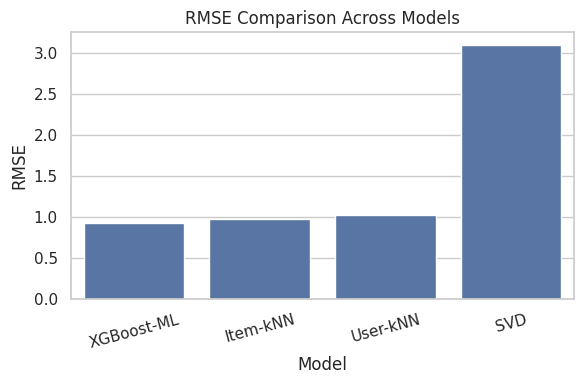

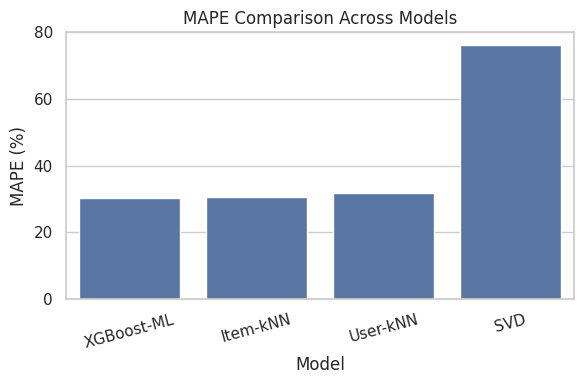

In [13]:
# 11. Model Comparison Plots

plt.figure(figsize=(6, 4))
sns.barplot(
    data=results_df,
    x="model",
    y="rmse",
)
plt.title("RMSE Comparison Across Models")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(
    data=results_df,
    x="model",
    y="mape",
)
plt.title("MAPE Comparison Across Models")
plt.xlabel("Model")
plt.ylabel("MAPE (%)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## 10. Error and Residual Analysis

To better understand where the models succeed or fail, we visualize:

1. **Predicted vs True Ratings** for SVD and ML model.
2. **Residual Histograms** (prediction error distribution).
3. **RMSE by True Rating Bucket** (e.g., low vs high ratings).

These plots are valuable for the discussion and limitations section of the report.


Using ML model key for plots: XGBoost-ML


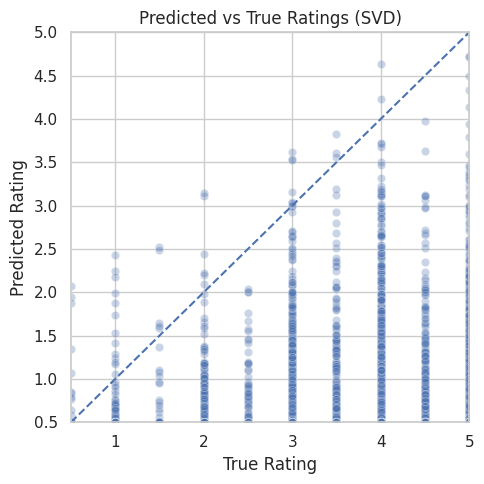

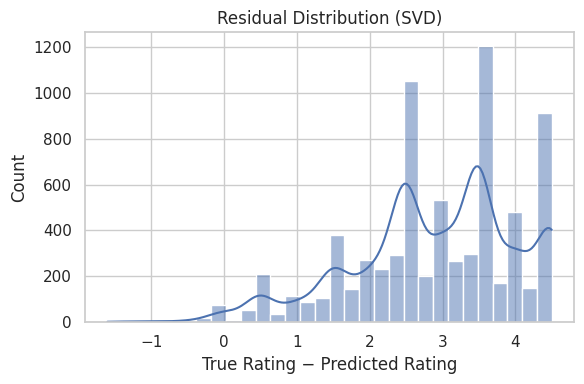

/tmp/ipython-input-88836385.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


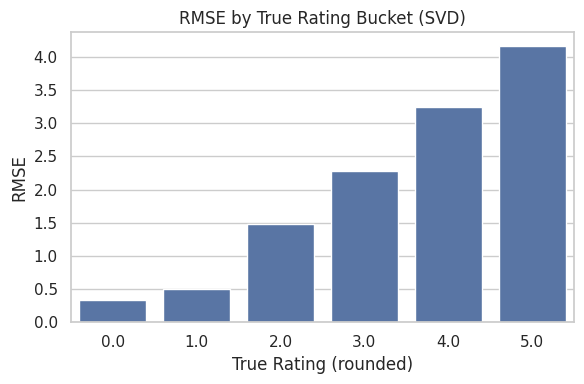

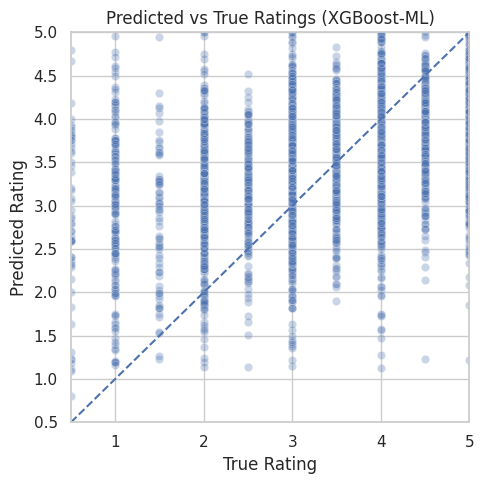

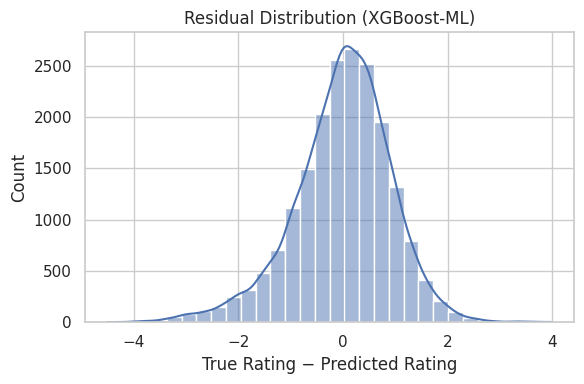

/tmp/ipython-input-88836385.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


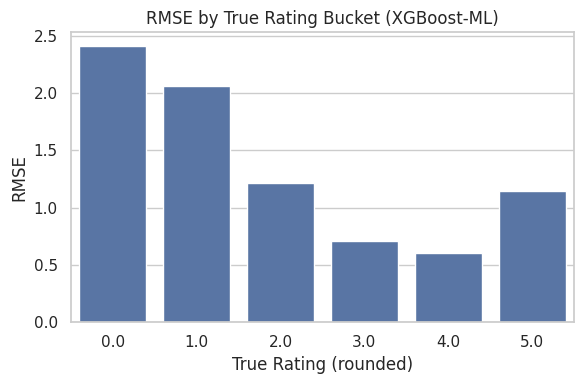

In [14]:
# 12. Error & Residual Analysis

def plot_pred_vs_true(
    df_pred: pd.DataFrame,
    model_name: str,
    sample_size: int = 5000,
) -> None:
    """
    Scatter plot of predicted vs true ratings.
    """
    df = df_pred.copy()
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=CFG.random_seed)

    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=df["rating"],
        y=df["y_pred"],
        alpha=0.3,
    )
    plt.plot([0.5, 5.0], [0.5, 5.0], linestyle="--")
    plt.title(f"Predicted vs True Ratings ({model_name})")
    plt.xlabel("True Rating")
    plt.ylabel("Predicted Rating")
    plt.xlim(0.5, 5.0)
    plt.ylim(0.5, 5.0)
    plt.tight_layout()
    plt.show()


def plot_residual_histogram(
    df_pred: pd.DataFrame,
    model_name: str,
) -> None:
    """
    Histogram of residuals (true - predicted).
    """
    residuals = df_pred["rating"] - df_pred["y_pred"]
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"Residual Distribution ({model_name})")
    plt.xlabel("True Rating − Predicted Rating")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


def plot_rmse_by_rating_bucket(
    df_pred: pd.DataFrame,
    model_name: str,
) -> None:
    """
    Compute RMSE for each true rating bucket (rounded rating).
    """
    df = df_pred.copy()
    df["rating_bucket"] = df["rating"].round()

    stats = (
        df.groupby("rating_bucket")
        .apply(
            lambda g: rmse(
                g["rating"].values,
                g["y_pred"].values,
            )
        )
        .reset_index(name="rmse_bucket")
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=stats,
        x="rating_bucket",
        y="rmse_bucket",
    )
    plt.title(f"RMSE by True Rating Bucket ({model_name})")
    plt.xlabel("True Rating (rounded)")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()


# Choose two representative models: SVD and ML model
svd_df_for_plots = model_predictions["SVD"]
ml_key = [k for k in model_predictions.keys() if "ML" in k][0]
ml_df_for_plots = model_predictions[ml_key]

print(f"Using ML model key for plots: {ml_key}")

# SVD plots
plot_pred_vs_true(svd_df_for_plots, "SVD")
plot_residual_histogram(svd_df_for_plots, "SVD")
plot_rmse_by_rating_bucket(svd_df_for_plots, "SVD")

# ML plots
plot_pred_vs_true(ml_df_for_plots, ml_key)
plot_residual_histogram(ml_df_for_plots, ml_key)
plot_rmse_by_rating_bucket(ml_df_for_plots, ml_key)


## 11. Similarity Structure Visualization (Optional)

For interpretability, we can visualize the cosine similarity structure
among a small set of movies. This gives intuition on how item-based CF
clusters similar movies.


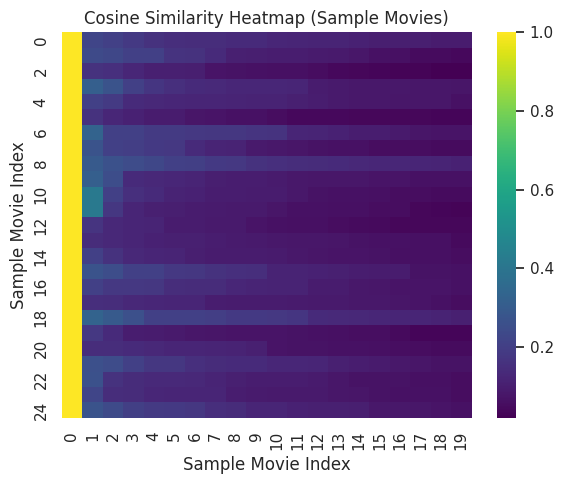

In [15]:
# 13. Item Similarity Heatmap (Optional)

def visualize_item_similarity_heatmap(
    user_item_matrix: sparse.csr_matrix,
    sample_item_indices: List[int],
    k: int = 20,
) -> None:
    """
    Visualize similarity among a subset of movies.
    """
    submatrix = user_item_matrix[:, sample_item_indices]
    knn = NearestNeighbors(
        n_neighbors=min(k, len(sample_item_indices)),
        metric="cosine",
        algorithm="brute",
        n_jobs=-1,
    )
    knn.fit(submatrix.T)

    distances, _ = knn.kneighbors(submatrix.T)
    sims = 1.0 - distances

    plt.figure(figsize=(6, 5))
    sns.heatmap(sims, cmap="viridis")
    plt.title("Cosine Similarity Heatmap (Sample Movies)")
    plt.xlabel("Sample Movie Index")
    plt.ylabel("Sample Movie Index")
    plt.tight_layout()
    plt.show()


# Example: randomly select 25 movies from the training set
sample_items = np.random.choice(
    user_item_matrix.shape[1],
    size=min(25, user_item_matrix.shape[1]),
    replace=False,
)
visualize_item_similarity_heatmap(user_item_matrix, sample_items.tolist())


## 12. Top-N Recommendation Demo

Finally, we generate top-N recommendations for a sample user using the
SVD model. This qualitative example is useful for the case study part
of the report.


In [16]:
# 14. Top-N Recommendation Demo


def get_top_n_recommendations(
    model,
    user_raw_id: int,
    user_id_to_index: Dict[int, int],
    index_to_movie_id: Dict[int, int],
    user_item_matrix: sparse.csr_matrix,
    movies_df: pd.DataFrame,
    n: int = 10,
) -> pd.DataFrame:
    """
    Generate Top-N movie recommendations for a given raw userId.
    """
    if user_raw_id not in user_id_to_index:
        raise ValueError(f"userId {user_raw_id} is unknown to the model.")

    user_index = user_id_to_index[user_raw_id]
    user_ratings_row = user_item_matrix[user_index, :]
    rated_item_indices = user_ratings_row.indices

    n_items = user_item_matrix.shape[1]
    candidate_indices = np.setdiff1d(
        np.arange(n_items, dtype=np.int32),
        rated_item_indices,
        assume_unique=True,
    )

    user_indices = np.full_like(candidate_indices, user_index)

    if hasattr(model, "predict_batch"):
        preds = model.predict_batch(user_indices, candidate_indices)
    else:
        preds = np.array(
            [
                model.predict_single(int(user_index), int(i))
                for i in candidate_indices
            ],
            dtype=np.float32,
        )

    top_n_idx = np.argsort(preds)[-n:][::-1]
    top_item_indices = candidate_indices[top_n_idx]
    top_scores = preds[top_n_idx]

    top_movie_ids = [index_to_movie_id[int(i)] for i in top_item_indices]
    top_movies = movies[movies["movieId"].isin(top_movie_ids)].copy()

    top_movies["movieId"] = top_movies["movieId"].astype(int)
    order_df = pd.DataFrame(
        {"movieId": top_movie_ids, "predicted_rating": top_scores}
    )

    result = order_df.merge(top_movies, on="movieId", how="left")
    return result[["movieId", "title", "genres", "predicted_rating"]]


example_user_raw_id = int(train_df["userId"].iloc[0])
top_recs_svd = get_top_n_recommendations(
    model=svd_model,
    user_raw_id=example_user_raw_id,
    user_id_to_index=user_id_to_index,
    index_to_movie_id=index_to_movie_id,
    user_item_matrix=user_item_matrix,
    movies_df=movies,
    n=10,
)

print(f"Top-10 SVD recommendations for userId={example_user_raw_id}:")
top_recs_svd


Top-10 SVD recommendations for userId=1:


,movieId,title,genres,predicted_rating
0,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,3.552053
1,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,2.514805
2,2987,Who Framed Roger Rabbit? (1988),Adventure|Animation|Children|Comedy|Crime|Fant...,2.233470
3,8874,Shaun of the Dead (2004),Comedy|Horror,2.186161
4,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2.144889
5,1127,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,2.070309
6,3793,X-Men (2000),Action|Adventure|Sci-Fi,2.008773
7,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,1.992753
8,1275,Highlander (1986),Action|Adventure|Fantasy,1.948712
9,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1.927310


## 13. Summary and Discussion (for Report)

Use the outputs and plots from this notebook to structure your final report:

- **Dataset and Preprocessing**
  - Describe MovieLens 20M, filtering thresholds, and leave-one-out split.

- **Models**
  - Explain Item-kNN, User-kNN, SVD-based MF, and Feature-based ML.
  - Highlight design choices (k, number of components, feature set).

- **Quantitative Results**
  - Use the RMSE/MAPE summary table and bar charts.
  - Discuss which model performs best and why.

- **Qualitative Analysis**
  - Include predicted vs true rating plots and residual distributions.
  - Show top-N recommendations for at least one user and discuss whether
    they seem reasonable.

- **Limitations and Future Work**
  - Cold-start issues (new users/movies).
  - Scalability to even larger catalogs.
  - Potential extensions:
    - Incorporate content features (genres, tags, text embeddings)
    - Neural recommendation models
    - Diversity / fairness constraints
